# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load Data

In [30]:
audio_files_path = r"C:\Users\HP\Desktop\FY Pro\X\Data Set\Data\AUDIO"

In [31]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [32]:
real_audio = r"C:\Users\HP\Desktop\FY Pro\X\Data Set\Demo\Real\linus-original-DEMO.mp3"
fake_audio = r"C:\Users\HP\Desktop\FY Pro\X\Data Set\Demo\Fake\linus-to-musk-DEMO.mp3"

# Visualization

In [33]:
print("Real Audio:")
IPython.display.Audio(real_audio)

Real Audio:


In [34]:
print("Fake Audio:")
IPython.display.Audio(fake_audio)

Fake Audio:


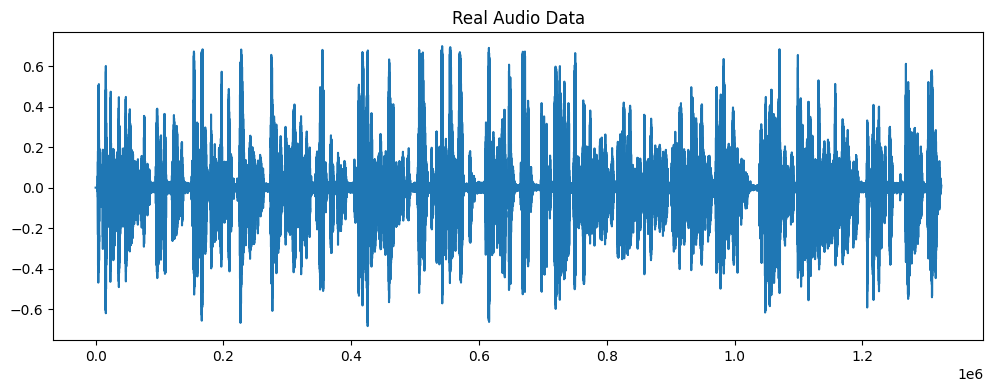

In [9]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

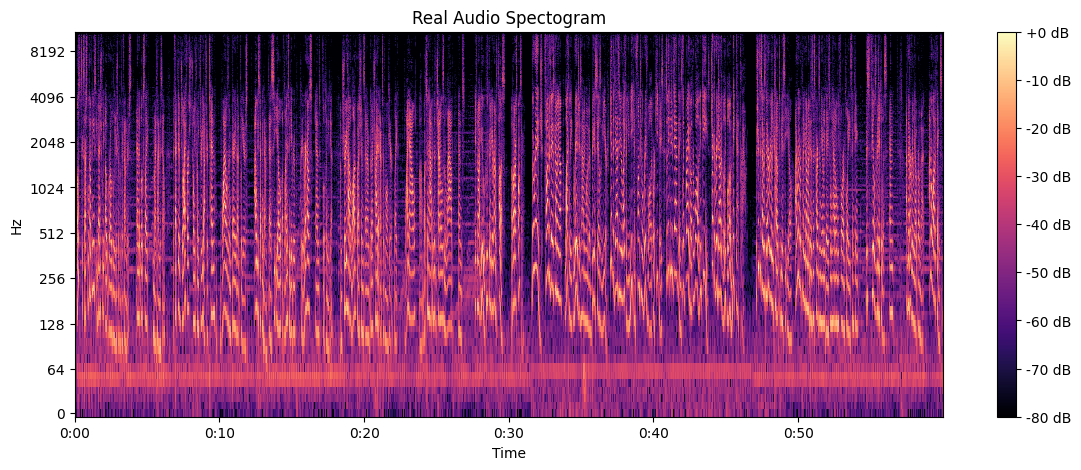

In [10]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

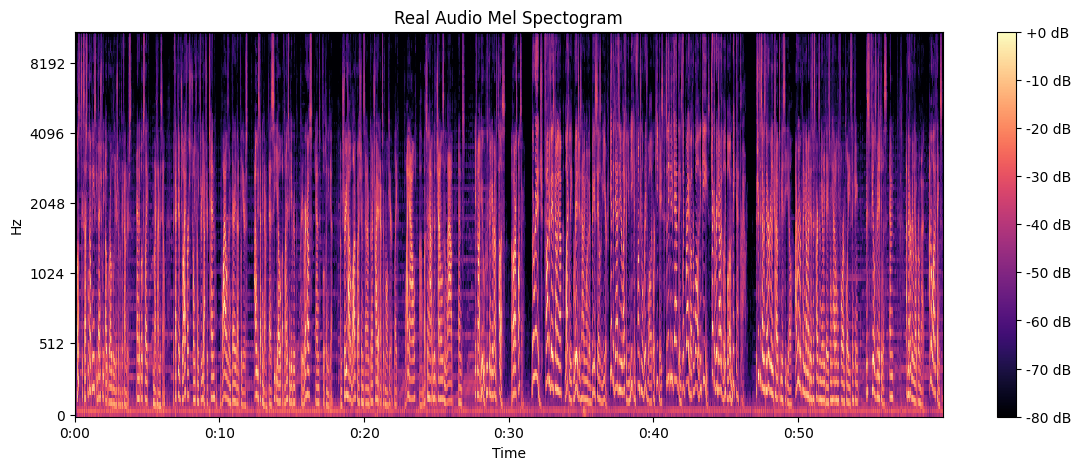

In [11]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

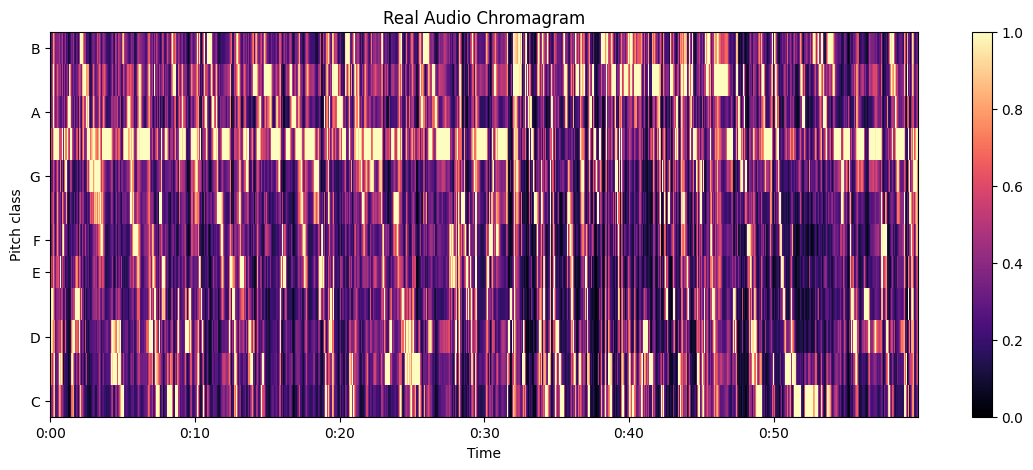

In [12]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

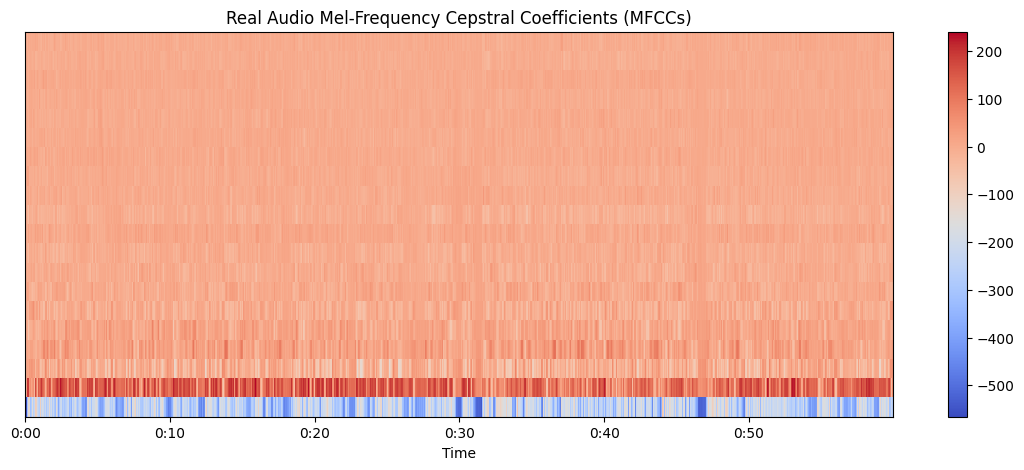

In [13]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

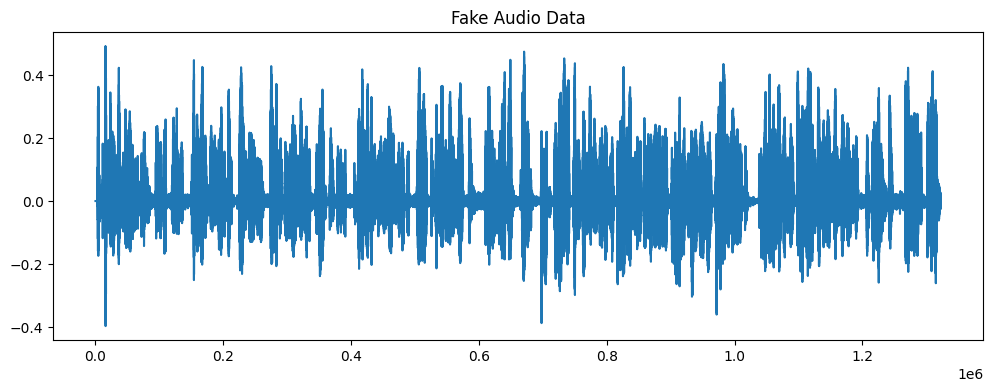

In [14]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

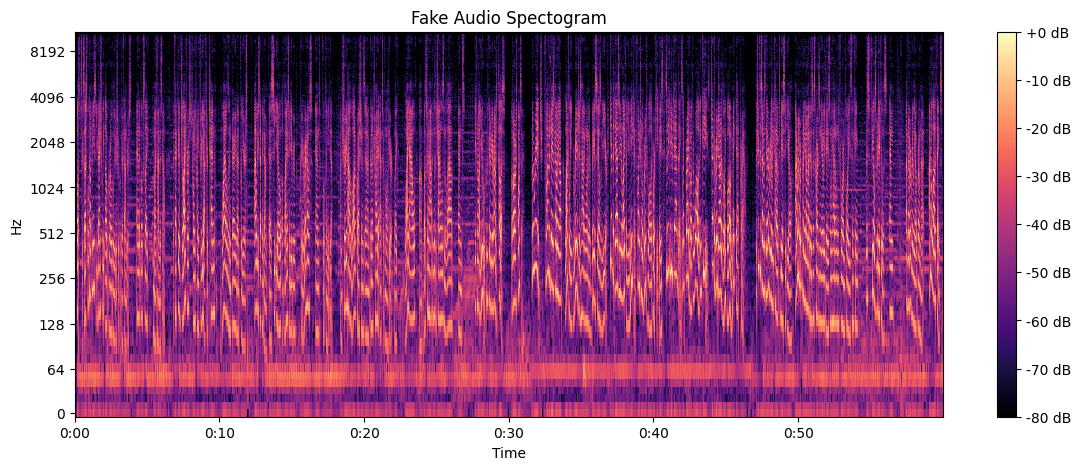

In [15]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

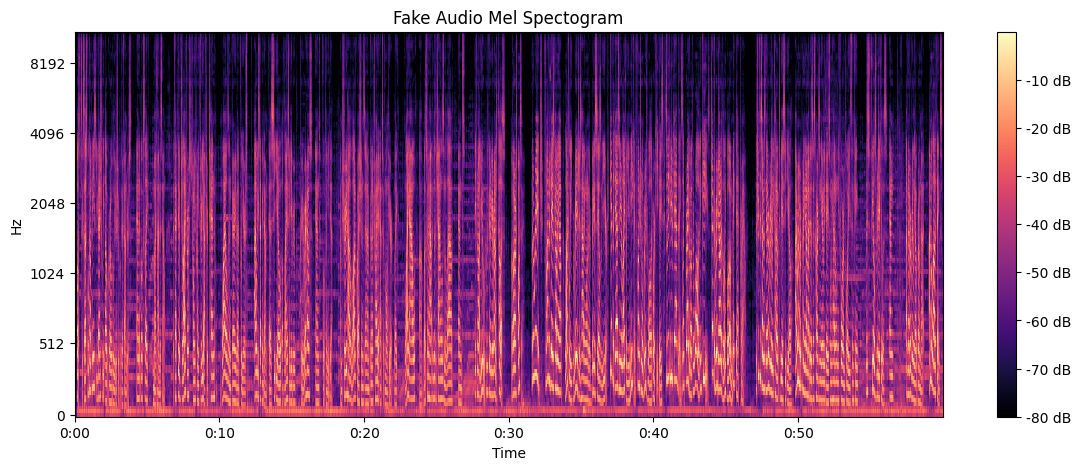

In [16]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

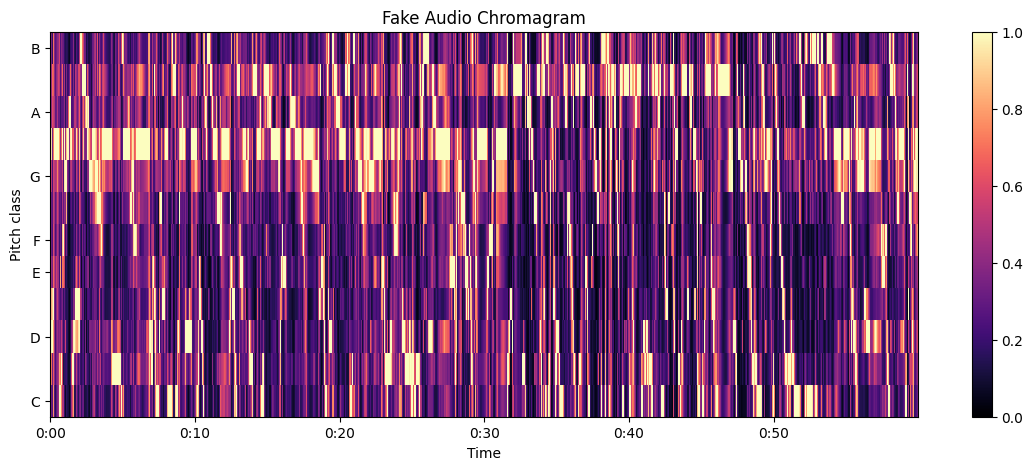

In [17]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

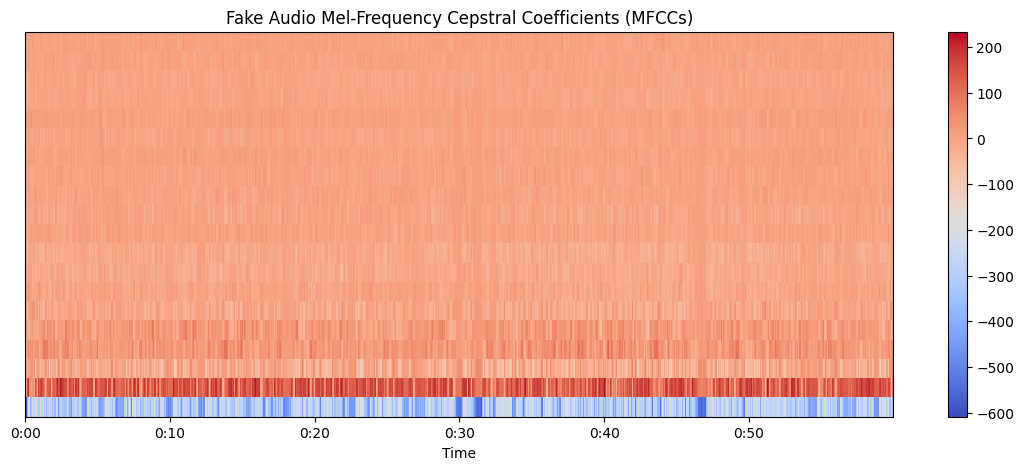

In [18]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

# Preprocess

In [35]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [00:57<00:00,  7.21s/it]


In [36]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

features class
0  [-260.1085, 100.856926, -25.453161, -0.2690358...  FAKE
1  [-258.9036, 93.91436, -27.627075, -1.9326235, ...  FAKE
2  [-268.50894, 118.533066, -38.89298, 13.812951,...  FAKE
3  [-272.68378, 101.50515, -22.251564, 4.101077, ...  FAKE
4  [-254.73932, 66.81036, -33.19487, -4.094302, -...  FAKE

In [37]:
feature_df["class"].value_counts()

FAKE    56
REAL     8
Name: class, dtype: int64

In [38]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [39]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


# Feature Scaling

In [40]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [41]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [42]:
y_resampled = to_categorical(y_resampled)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [44]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [45]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [47]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=50)

Epoch 1/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3829 - accuracy: 0.8090 - val_loss: 0.4784 - val_accuracy: 0.8261
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3977 - accuracy: 0.8539 - val_loss: 0.4862 - val_accuracy: 0.7391
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.5564 - accuracy: 0.8315 - val_loss: 0.5076 - val_accuracy: 0.7826
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4045 - accuracy: 0.8539 - val_loss: 0.5626 - val_accuracy: 0.7391
Epoch 5/50
45/45 [==============================] - 0s 4ms/step - loss: 0.3788 - accuracy: 0.8090 - val_loss: 0.4591 - val_accuracy: 0.7391
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3876 - accuracy: 0.8427 - val_loss: 0.4873 - val_accuracy: 0.7391
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3599 - accuracy: 0.8876 - val_loss: 0.4179 - val_accuracy: 0.7391
Epoch 8/50
45/45 [==

In [57]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - 0s 24ms/step - loss: 0.3054 - accuracy: 0.9130
Test Loss: 0.30535176396369934
Test Accuracy: 0.9130434989929199


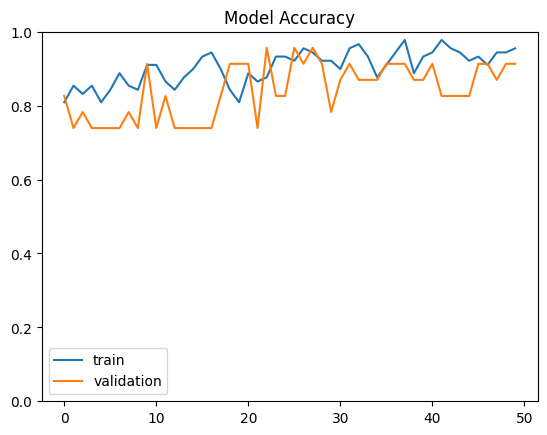

In [58]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

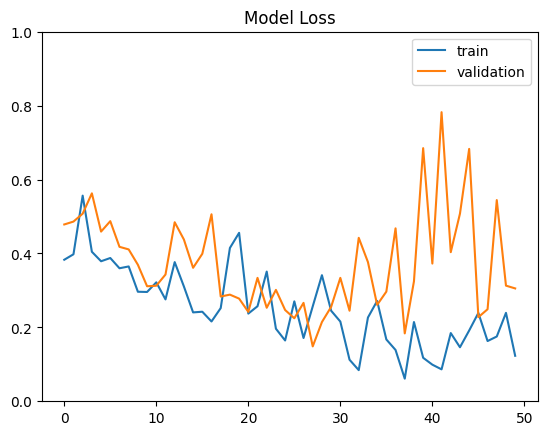

In [59]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [ ]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    
    result_array = model.predict(mfccs_features_scaled)
    
    print("Prediction Probabilities:", result_array)
    
    le = LabelEncoder()
    le.fit(["REAL", "FAKE"])  
    
    print("Label Mapping:", le.classes_) 

    result = np.argmax(result_array[0]) 
    result_class = le.classes_[result]   
    
    print("Predicted Index:", result)
    print("Result:", result_class)
    
    return result_class, result_array[0]

In [67]:
test_real = r"C:\Users\HP\Desktop\FY Pro\X\Data Set\Demo\Real\linus-original-DEMO.mp3"
test_fake = r"C:\Users\HP\Desktop\FY Pro\X\Data Set\Demo\Fake\linus-to-musk-DEMO.mp3"

In [68]:
detect_fake(test_real)

Prediction Probabilities: [[0.01545646 0.9845435 ]]
Label Mapping: ['FAKE' 'REAL']
Predicted Index: 1
Result: REAL


('REAL', array([0.01545646, 0.9845435 ], dtype=float32))

In [69]:
detect_fake(test_fake)

Prediction Probabilities: [[0.98747534 0.01252468]]
Label Mapping: ['FAKE' 'REAL']
Predicted Index: 0
Result: FAKE


('FAKE', array([0.98747534, 0.01252468], dtype=float32))

In [70]:
model.save('my_model.keras')

In [71]:
model.save('my_model.h5')